In [1]:
# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/DL/100-bird-species.zip -d /content/100-bird-species

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Defining dataset path
data_dir = '/content/100-bird-species/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'

In [4]:
# Defining train transform and val transform along with data
train_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  # transforms.Resize((32, 32)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

val_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  # transforms.Resize((32, 32)),
  transforms.ToTensor()
])

In [5]:
#Creating dataset
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(valid_dir,transform=val_transform)

In [6]:
batch_size = 64
# Creating dataloader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size, shuffle=True)

In [7]:
# Defining num of classes
num_classes = len(train_dataset.classes)
print(num_classes)

525


In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
# Pushing data to device
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # preds는 예측 결과 클래스의 인덱스
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(2048, num_classes))
                                        # nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [13]:
model = to_device(ResNet9(3, num_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
history = [evaluate(model, valid_loader)]
history

[{'val_loss': 6.2630615234375, 'val_acc': 0.0018601190531626344}]

In [16]:
epochs = 10 - 1
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [17]:
history += fit_one_cycle(epochs, max_lr, model, train_loader, valid_loader, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00330, train_loss: 4.9977, val_loss: 3.2854, val_acc: 0.3002
Epoch [1], last_lr: 0.00849, train_loss: 2.8958, val_loss: 2.6848, val_acc: 0.4293
Epoch [2], last_lr: 0.00994, train_loss: 2.4269, val_loss: 2.2184, val_acc: 0.5030
Epoch [3], last_lr: 0.00899, train_loss: 2.1221, val_loss: 1.6528, val_acc: 0.6034
Epoch [4], last_lr: 0.00706, train_loss: 1.8204, val_loss: 1.5016, val_acc: 0.6507
Epoch [5], last_lr: 0.00463, train_loss: 1.4852, val_loss: 1.1689, val_acc: 0.7340
Epoch [6], last_lr: 0.00229, train_loss: 1.1031, val_loss: 0.6855, val_acc: 0.8296
Epoch [7], last_lr: 0.00061, train_loss: 0.7339, val_loss: 0.4891, val_acc: 0.8705
Epoch [8], last_lr: 0.00000, train_loss: 0.4918, val_loss: 0.4440, val_acc: 0.8888


In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

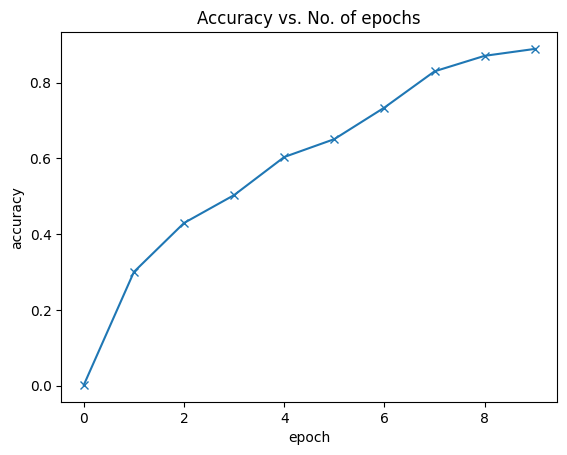

In [19]:
plot_accuracies(history)

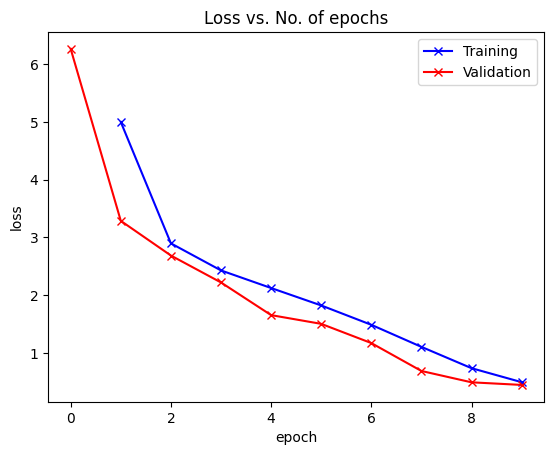

In [20]:
plot_losses(history)

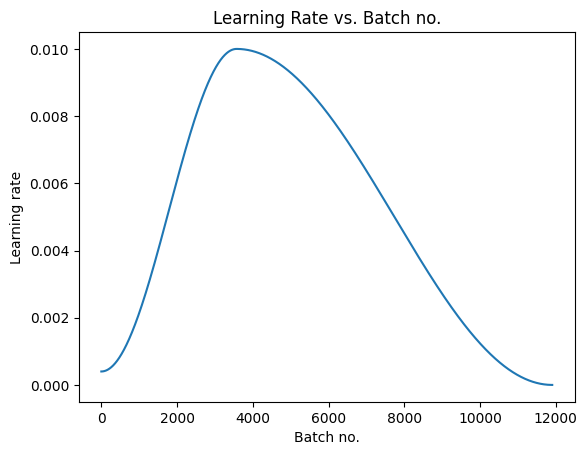

In [21]:
plot_lrs(history)

In [22]:
test_dataset = ImageFolder(data_dir+'/test', transform=val_transform)
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.29043886065483093, 'val_acc': 0.9238381385803223}